In [6]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from importlib import reload
import models_new
reload(models_new)
from models_new import Renorm_Dynamic
from EI_calculation import approx_ei


import dynamic_models_sis_new
reload(dynamic_models_sis_new)
from dynamic_models_sis_new import Simple_Spring_Model
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:5') if use_cuda else torch.device('cpu')
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

def kde_density(X):
    is_cuda = X.is_cuda  #True is stored in GPU.
    ldev = X.device  #Running the allocation of memory within a certain space.
    dim = X.size()[1] #The number of columns in obtaining the data is the dimension.
    kde = KernelDensity(kernel='gaussian', bandwidth=0.02, atol=0.2).fit(X.cpu().data.numpy())
    log_density = kde.score_samples(X.cpu().data.numpy())
    return log_density, kde



def to_weights(log_w, temperature): 
    #Normalize log_w using softmax and obtain the weights.
    logsoft = nn.LogSoftmax(dim = 0)
    weights = torch.exp(logsoft(log_w/temperature))
    return weights



def test_model_causal_multi_sis(spring_data,samples,MAE_raw,net1,sigma,scale,L=0.5, num_samples = 1000, bigL = 100):
    #EI calculation function
    sigmas_matrix=torch.zeros([2,2],device=device)
    s,sp,l,lp=spring_data
    encode=net1.encoding(sp)
    predicts1, latent1, latentp1 = net1(s)
    log_density, k_model_n = kde_density(latent1)
    log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  #Uniform distribution probability distribution
    logp = log_rho - log_density  #The difference between two probability distributions.
    weights = to_weights(logp, temperature) * samples
    if use_cuda:
        weights = weights.cuda(device=device)
    weights=weights.unsqueeze(1)
    mae1 = MAE_raw(latentp1, encode) * torch.cat((weights,weights),1)
    sigmas=mae1.mean(axis=0)
    
    sigmas_matrix = torch.diag(sigmas)
    ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(net1.dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                       num_samples = 1000, L=bigL, easy=True, device=device) 

    return ei, sigmas,weights

def calculate_net_model2(model,s,i,steps = 100,stochastic=False,seed=10,rou=-0.5,dt=1):
    #Out-of-distribution generalization testing function
    spring = Simple_Spring_Model(device=device)

    if stochastic:
        z = torch.randn([1, 2], device=device)*L/2 
    else:
        z=torch.tensor([[s,i]],device=device) 
    s = spring.perturb(z, sigma,rou)
    #s=(s-s.mean())/s.std()
    s_hist, z_hist = model.multi_step_prediction(s, steps)
    if use_cuda:
        s_hist = s_hist.cpu()
        z_hist = z_hist.cpu()

    rs_hist, rsn_hist = spring.multi_steps_sir(z, steps, sigma,rou=rou,dt=dt) #sir
    if use_cuda:
        rs_hist = rs_hist.cpu()
        rsn_hist = rsn_hist.cpu()

    means=torch.mean(torch.abs(rsn_hist-s_hist[1:,:]),1)
    cums=torch.cumsum(means, 0)
    mae_fin=cums.data/np.linspace(1, steps, steps)


    return mae_fin[-1]

from datetime import datetime
t0 = datetime.now()
def cpt(s):
    #Timing function
    global t0
    t = datetime.now()
    print(f'check point{s:->10}-> {t.time()}; lasting {t - t0} seconds')
    t0 = t
device

device(type='cpu')

In [2]:
from datetime import datetime
t0 = datetime.now()
def cpt(s):
    global t0
    t = datetime.now()
    print(f'check point{s:->10}-> {t.time()}; lasting {t - t0} seconds')
    t0 = t
results = []
results_nn = []
encoder_results = []
temperature = 1
encoder_interval = 1000
experiments = 1
sz = 4
scale = 2
L = 5
hidden_units = 64
sigma = 0.03
steps = 7
batch_size = steps * 100 #20
mae2_w= 3
rou=-0.5
cpt('begin')
z_scale=sz-scale
prior = distributions.MultivariateNormal(torch.zeros(z_scale), torch.eye(z_scale))
MAE = torch.nn.L1Loss()
MAE_raw = torch.nn.L1Loss(reduction='none')
test_start=0
test_end=0.3
m_step=10
for experiment in range(experiments):
    mul_batch_size = [0,10,4500,1500]
    seed = 1+experiment
    mae3_w = 0 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5) #sir
    
    print(ss.shape)
    # ss,sps,ls,lps = spring.generate_multistep(batch_size=mul_batch_size, steps=steps, sigma=sigma, L=L)
    sample_num = ss.size()[0] # batch_size * (steps * (k1 + k2) -1)
    weights2 = torch.ones(sample_num, device=device) 
    net_nn = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    
    net_nn.load_state_dict(torch.load('netnn_init_trnorm0.1+zero_seed=4.mdl').state_dict())
            
    nname="_trnorm0.1+zero_4_501"    
    net_nn.to(device=device)
    optimizer2 = torch.optim.Adam([p for p in net_nn.parameters() if p.requires_grad==True], lr=1e-4)    
    result_nn = []
    ei_nn=[]
    term1_nn=[]
    term2_nn=[]
    losses_nn=[]
    MAEs_nn=[]
    data_models = []
    spring = Simple_Spring_Model(device=device)
    T  = 3001
    T2  = 30001 
    T3  = 150001
    cpt('out')
    for epoch in range(T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp = ss[start:end], sps[start:end], ls[start:end], lps[start:end]
        predicts, latent, latentp,z = net_nn.forward_train(s,sp)
        mae = MAE(sp, predicts)
        loss_nn= mae 
        optimizer2.zero_grad()
        loss_nn.backward()
        optimizer2.step()

        
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_nn=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 #sir
                mae_nn+=calculate_net_model2(net_nn,s,i,steps=m_step,seed=seed,rou=rou)
            mae_nn/=20
            ei1, sigmas1,weightsnn=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net_nn,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('Train loss: CommonNet= %.4f' %  mae.item())
            #print('Evalu loss: BiNet= %.4f, CommonNet= %.4f' % (mae_net, mae_nn))
            print('dEI: CommonNet= %.4f' % ei1[0])
            #print('sigma: BiNet= %.4f, CommonNet= %.4f'%(sigmas0[0]*sigmas0[1,1], sigmas1[0,0]*sigmas1[1,1]))
            print('term1: CommonNet= %.4f'% ei1[3])
            print('term2: CommonNet= %.4f'% ei1[4])
            #print('mae2= %.4f'%mae2.item())
            #print('dett: BiNet= %.4f, CommonNet= %.4f'%(ei0[5], ei1[5]))
            print(120*'-')
  
            ei_nn.append(ei1[0])
            term1_nn.append(ei1[3].item())
            term2_nn.append(ei1[4].item())
            losses_nn.append(mae.item())
            
            result_nn.append([ei1[0], ei1[3].item(), ei1[4].item(),mae_nn.item()]) #
            cpt('o_1')
            
   
    results_nn.append(result_nn)

##########################################################################################################################    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Generating Data
    spring = Simple_Spring_Model(device=device)
    
    #ss,sps,ls,lps = spring.generate_data_norm(sample_num, sigma, L) #l原始输入数据，s加了扰动后的数据，p下一时刻的数据
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5) #sir
    print(ss.shape)
    # ss,sps,ls,lps = spring.generate_multistep(batch_size=mul_batch_size, steps=steps, sigma=sigma, L=L)
    sample_num = ss.size()[0] # batch_size * (steps * (k1 + k2) -1)
    weights = torch.ones(sample_num, device=device) 
    #weights2 = torch.ones(sample_num, device=device) 
    net = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)


    net.load_state_dict(torch.load('netwn_init_trnorm0.1+zero_seed=4.mdl').state_dict())
   
    net.to(device=device)
    #net_nn.to(device=device)
    optimizer1 = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
    #optimizer2 = torch.optim.Adam([p for p in net_nn.parameters() if p.requires_grad==True], lr=1e-4)    
    optimizer3 = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
    
    result = []
    ei_net=[]
    term1_net=[]
    term2_net=[]
    loss_net=[]
    #loss_nn=[]
    MAEs_net=[]
    #MAEs_nn=[]
    data_models = []
    spring = Simple_Spring_Model(device=device)
    cpt('out')
    for epoch in range(T):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp, w = ss[start:end], sps[start:end], ls[start:end], lps[start:end], weights[start:end]
        
        predicts1, latent1, latentp1,z1 = net.forward_train(s,sp)
        mae1 =  MAE(sp, predicts1)
        #mae3 = -prior.log_prob(z1).mean()
        loss = mae1 
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        #Frozen Encoder
        for p in net.flow.parameters():
            p.requires_grad = False
            
        latent1=net.encoding(s)
        predicts0, latent0, latentp0 = net.back_forward(sp) 
        mae2 = (MAE_raw(latent1, latentp0).mean(axis=1) * w).mean()  #
        optimizer3.zero_grad()
        mae2.backward()
        optimizer3.step()
        
        for p in net.flow.parameters():
            p.requires_grad = True
            
    
       
        
        if epoch % 500 == 0:
            cpt('o_0')

            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_net=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 #sir
                #mae_nn+=calculate_net_model2(net_nn,s,i,steps=200,seed=seed)
                mae_net+=calculate_net_model2(net,s,i,steps=m_step,seed=seed,rou=rou)
            #mae_nn/=20
            mae_net/=20
            ei0, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net,sigma,scale, L=L,num_samples = 1000, bigL = L)
        
            #print('Train loss: BiNet= %.4f, inverse= %.4f' % (loss.item(), mae2.item()))
            #print('Evalu loss: BiNet= %.4f, CommonNet= %.4f' % (mae_net, mae_nn))
            print('dEI: BiNet= %.4f' % ei0[0])  #？区别 ei0  ei1;  net net_nn
            #print('sigma: BiNet= %.4f, CommonNet= %.4f'%(sigmas0[0]*sigmas0[1,1], sigmas1[0,0]*sigmas1[1,1]))
            print('term1: BiNet= %.4f ' % ei0[3])
            print('term2: BiNet= %.4f '% ei0[4])
            #print('mae2= %.4f'%mae2.item())
            #print('dett: BiNet= %.4f, CommonNet= %.4f'%(ei0[5], ei1[5]))
            print(120*'-')
            ei_net.append(ei0[0])
            term1_net.append(ei0[3].item())
            term2_net.append(ei0[4].item())
            loss_net.append(mae1.item())

            
            result.append([ei0[0],ei0[3].item(), ei0[4].item(),mae_net.item()]) #
            cpt('o_1')
            
    for epoch in range(T,T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp, w = ss[start:end], sps[start:end], ls[start:end], lps[start:end], weights[start:end]

        predicts1, latent1, latentp1, z1 = net.forward_train(s,sp)
        predicts0, latent0, latentp0 = net.back_forward(sp) 
        mae1 = (MAE_raw(sp, predicts1).mean(axis=1) * w).mean() 
        mae2 = (MAE_raw(latent1,latentp0).mean(axis=1) * w).mean() 
        loss = mae1+mae2_w*mae2
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        
        if epoch > 0 and epoch % encoder_interval == 0:
            cpt('w_0')
            # preparing training data
            net_temp = Renorm_Dynamic(sym_size = sz, latent_size = scale, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=False, device = device)
            net_temp.load_state_dict(net.state_dict())
            net_temp.to(device=device)
            encodings = net_temp.encoding(ss)  
            cpt('w_1')
            log_density, k_model_n = kde_density(encodings)  # Probability Distribution of Encoded Data
            cpt('w_2')
            log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  #Probability Distribution of Uniform Distribution
            logp = log_rho - log_density  
            weights = to_weights(logp, temperature) * sample_num
            if use_cuda:
                weights = weights.cuda(device=device)
            weights=torch.where(weights<10,weights,10.)
            cpt('w_3')
            
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_net=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 
                mae_net+=calculate_net_model2(net,s,i,steps=m_step,seed=seed,rou=rou)
            mae_net/=20

            ei0, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,10000,MAE_raw,net,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('dEI: BiNet= %.4f' % ei0[0]) 
            print('term1: BiNet= %.4f ' % ei0[3])
            print('term2: BiNet= %.4f '% ei0[4])
            print(120*'-')
            result.append([ei0[0],ei0[3].item(), ei0[4].item(),mae_net.item()])
            ei_net.append(ei0[0])
            term1_net.append(ei0[3].item())
            term2_net.append(ei0[4].item())
            loss_net.append(mae1.item())

            cpt('o_1')
         
    results.append(result)  
    
#import pickle
#with open('5 OOD L=1 717.pkl', 'wb') as f:
#     pickle.dump((results,results_nn), f)   


check point-----begin-> 13:22:31.805544; lasting 0:00:00.001008 seconds
torch.Size([42049, 4])
check point-------out-> 13:22:34.047462; lasting 0:00:02.241918 seconds
check point-------o_0-> 13:22:34.097436; lasting 0:00:00.049974 seconds
0 / 1 Epoch: 0
Train loss: CommonNet= 0.4432
dEI: CommonNet= 0.4397
term1: CommonNet= -0.5449
term2: CommonNet= 1.4243
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:22:39.565272; lasting 0:00:05.467836 seconds
check point-------o_0-> 13:23:01.932564; lasting 0:00:22.367292 seconds
0 / 1 Epoch: 500
Train loss: CommonNet= 0.0989
dEI: CommonNet= 0.8636
term1: CommonNet= 0.2824
term2: CommonNet= 1.4449
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:23:06.464049; lasting 0:00:04.531485 seconds
check point-------o_0-> 13:23:24.585900; lasting 0:00:18.121851 

check point-------o_0-> 13:35:07.468614; lasting 0:00:21.020569 seconds
0 / 1 Epoch: 10500
Train loss: CommonNet= 0.0288
dEI: CommonNet= 1.9252
term1: CommonNet= 2.4547
term2: CommonNet= 1.3957
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:35:22.808652; lasting 0:00:15.340038 seconds
check point-------o_0-> 13:35:47.605388; lasting 0:00:24.796736 seconds
0 / 1 Epoch: 11000
Train loss: CommonNet= 0.0289
dEI: CommonNet= 1.9747
term1: CommonNet= 2.5620
term2: CommonNet= 1.3874
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:36:02.580431; lasting 0:00:14.975043 seconds
check point-------o_0-> 13:36:27.563182; lasting 0:00:24.982751 seconds
0 / 1 Epoch: 11500
Train loss: CommonNet= 0.0282
dEI: CommonNet= 1.9420
term1: CommonNet= 2.4939
term2: CommonNet= 1.3901
--------------------------------

Train loss: CommonNet= 0.0277
dEI: CommonNet= 2.1184
term1: CommonNet= 2.8930
term2: CommonNet= 1.3438
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:47:47.395619; lasting 0:00:11.592514 seconds
check point-------o_0-> 13:48:07.480068; lasting 0:00:20.084449 seconds
0 / 1 Epoch: 21500
Train loss: CommonNet= 0.0279
dEI: CommonNet= 2.1397
term1: CommonNet= 2.9391
term2: CommonNet= 1.3404
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 13:48:18.586900; lasting 0:00:11.106832 seconds
check point-------o_0-> 13:48:39.221828; lasting 0:00:20.634928 seconds
0 / 1 Epoch: 22000
Train loss: CommonNet= 0.0276
dEI: CommonNet= 2.1008
term1: CommonNet= 2.8595
term2: CommonNet= 1.3420
------------------------------------------------------------------------------------------------------------------------
ch

check point-------o_0-> 14:03:28.146689; lasting 0:01:02.177531 seconds
0 / 1 Epoch: 1500
dEI: BiNet= 1.0445
term1: BiNet= 0.5916 
term2: BiNet= 1.4973 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:03:38.115219; lasting 0:00:09.968530 seconds
check point-------o_0-> 14:04:31.670546; lasting 0:00:53.555327 seconds
0 / 1 Epoch: 2000
dEI: BiNet= 1.0652
term1: BiNet= 0.6377 
term2: BiNet= 1.4928 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:04:41.869676; lasting 0:00:10.199130 seconds
check point-------o_0-> 14:05:30.958914; lasting 0:00:49.089238 seconds
0 / 1 Epoch: 2500
dEI: BiNet= 1.0378
term1: BiNet= 0.6068 
term2: BiNet= 1.4688 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 14:05:40.0

check point-------o_0-> 15:03:01.831382; lasting 0:01:11.593630 seconds
0 / 1 Epoch: 10500
dEI: BiNet= 2.1707
term1: BiNet= 3.0288 
term2: BiNet= 1.3125 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:03:19.243706; lasting 0:00:17.412324 seconds
check point-------w_0-> 15:04:16.548158; lasting 0:00:57.304452 seconds
check point-------w_1-> 15:04:16.793947; lasting 0:00:00.245789 seconds
check point-------w_2-> 15:08:02.062657; lasting 0:03:45.268710 seconds
check point-------w_3-> 15:08:02.065611; lasting 0:00:00.002954 seconds
check point-------o_0-> 15:08:02.065611; lasting 0:00:00 seconds
0 / 1 Epoch: 11000
dEI: BiNet= 2.1560
term1: BiNet= 3.0081 
term2: BiNet= 1.3039 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:08:10.991867; lasting 0:00:08.926256 seconds
check point-------o_0-> 1

check point-------w_2-> 15:39:19.795758; lasting 0:02:33.253703 seconds
check point-------w_3-> 15:39:19.798567; lasting 0:00:00.002809 seconds
check point-------o_0-> 15:39:19.798567; lasting 0:00:00 seconds
0 / 1 Epoch: 19000
dEI: BiNet= 2.2470
term1: BiNet= 3.3894 
term2: BiNet= 1.1047 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:39:28.380421; lasting 0:00:08.581854 seconds
check point-------o_0-> 15:39:58.083938; lasting 0:00:29.703517 seconds
0 / 1 Epoch: 19500
dEI: BiNet= 2.2364
term1: BiNet= 3.3620 
term2: BiNet= 1.1109 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 15:40:07.484253; lasting 0:00:09.400315 seconds
check point-------w_0-> 15:40:37.468977; lasting 0:00:29.984724 seconds
check point-------w_1-> 15:40:37.623863; lasting 0:00:00.154886 seconds
check point-------w_2-> 1

check point-------o_0-> 16:11:15.338597; lasting 0:00:31.014310 seconds
0 / 1 Epoch: 27500
dEI: BiNet= 2.3199
term1: BiNet= 3.7041 
term2: BiNet= 0.9356 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:11:25.603639; lasting 0:00:10.265042 seconds
check point-------w_0-> 16:11:54.792206; lasting 0:00:29.188567 seconds
check point-------w_1-> 16:11:54.953196; lasting 0:00:00.160990 seconds
check point-------w_2-> 16:14:36.873105; lasting 0:02:41.919909 seconds
check point-------w_3-> 16:14:36.875090; lasting 0:00:00.001985 seconds
check point-------o_0-> 16:14:36.875090; lasting 0:00:00 seconds
0 / 1 Epoch: 28000
dEI: BiNet= 2.3190
term1: BiNet= 3.6886 
term2: BiNet= 0.9494 
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:14:46.987099; lasting 0:00:10.112009 seconds
check point-------o_0-> 1

In [3]:
#VAE construction and training
def test_vae_causal_multi_sis(spring_data,samples,MAE_raw,vae,sigma,scale,L=0.5, num_samples = 1000, bigL = 100):
    #EI calculation function
    sigmas_matrix=torch.zeros([2,2],device=device)
    s,sp,l,lp=spring_data
    latent_params = vae.encoder(sp)
    mu_p, logvar_p = torch.chunk(latent_params, 2, dim=1)
    predicts, mu, logvar = vae.forward(s)
    log_density, k_model_n = kde_density(mu)
    log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  #Uniform distribution probability distribution
    logp = log_rho - log_density  #The difference between two probability distributions.
    weights = to_weights(logp, temperature) * samples
    if use_cuda:
        weights = weights.cuda(device=device)
    weights=weights.unsqueeze(1)
    mae1 = MAE_raw(mu, mu_p) * torch.cat((weights,weights),1)
    sigmas=mae1.mean(axis=0)
    
    sigmas_matrix = torch.diag(sigmas)
    ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(vae.dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                       num_samples = 1000, L=bigL, easy=True, device=device) 

    return ei, sigmas,weights

def calculate_vae_mulistep(vae,s,i,steps = 100,stochastic=False,seed=10,rou=-0.5,dt=1):
    #Out-of-distribution generalization testing function
    spring = Simple_Spring_Model(device=device)
    if stochastic:
        z = torch.randn([1, 2], device=device)*L/2 
    else:
        z=torch.tensor([[s,i]],device=device) 
    s = spring.perturb(z, sigma,rou)
    s_hist = vae.mulistep_forward(s, steps=steps)
    if use_cuda:
        s_hist = s_hist.cpu()

    rs_hist, rsn_hist = spring.multi_steps_sir(z, steps, sigma,rou=rou,dt=dt) #sir
    if use_cuda:
        rs_hist = rs_hist.cpu()
        rsn_hist = rsn_hist.cpu()

    means=torch.mean(torch.abs(rsn_hist-s_hist[1:,:]),1)
    cums=torch.cumsum(means, 0)
    mae_fin=cums.data/np.linspace(1, steps, steps)
    return mae_fin[-1]

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim * 2)  # 输出均值和方差
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()  # 输出范围在0到1之间
        )
        self.dynamics=nn.Sequential(nn.Linear(latent_dim, hidden_dim2), nn.LeakyReLU(), 
                                 nn.Linear(hidden_dim2, hidden_dim2), nn.LeakyReLU(), 
                                 nn.Linear(hidden_dim2, latent_dim))
        self.inverse_dynamics=nn.Sequential(nn.Linear(latent_dim, hidden_dim2), nn.LeakyReLU(), 
                                 nn.Linear(hidden_dim2, hidden_dim2), nn.LeakyReLU(), 
                                 nn.Linear(hidden_dim2, latent_dim))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.1 * logvar)
        eps = torch.randn_like(std)
        z = mu + 0.0001*eps * std
        return z

    def forward(self, x,steps=1):
        x = x.view(x.size(0), -1)
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        for step in range(steps):
            mu=mu+self.dynamics(mu)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar
    def mulistep_forward(self, x,steps=10):
        x = x.view(x.size(0), -1)
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        x_list=x#torch.zeros([x.size(0),steps])
        for step in range(steps):
            mu=mu+self.dynamics(mu)
            z = self.reparameterize(mu, logvar)
            reconstructed_x = self.decoder(z)
            x_list= torch.cat((x_list,reconstructed_x),0)
        return x_list
    
vae=VAE(input_dim=4,hidden_dim1=64, hidden_dim2=64,latent_dim=2)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(vae)

34956

In [4]:
temperature = 1
encoder_interval = 1000
experiments = 1
MAE = torch.nn.L1Loss()
MAE_raw = torch.nn.L1Loss(reduction='none')
mul_batch_size = [0,5000,3000,1000]
test_start=0
test_end=0.3
m_step=10
results_vae=[]
sz = 4
scale = 2
steps=7
batch_size=700
rou=-0.5
sigma = 0.03
L=1
T  = 3001
T2  = 30001 
cpt('out')
spring = Simple_Spring_Model(device=device) 
for experiment in range(experiments):
    seed=1+experiment
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    vae=VAE(input_dim=4,hidden_dim1=64, hidden_dim2=64,latent_dim=2)
    vae.to(device=device)
    optimizer2 = torch.optim.Adam([p for p in vae.parameters() if p.requires_grad==True], lr=1e-4)  
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5)
    sample_num = ss.size()[0]
    result_vae=[]
    loss_vae=[]
    ei_vae=[]
    for epoch in range(T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp = ss[start:end], sps[start:end], ls[start:end], lps[start:end]
        predicts, mu, logvar = vae.forward(s)
        mae = MAE(sp, predicts)
        loss_nn= mae 
        optimizer2.zero_grad()
        loss_nn.backward()
        optimizer2.step()


        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_vae=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 #sir
                mae_vae+=calculate_vae_mulistep(vae,s,i,steps=m_step,seed=seed,rou=rou)
            mae_vae/=20
            ei1, sigmas1,weightsnn=test_vae_causal_multi_sis(spring_data,10000,MAE_raw,vae,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('Train loss: VAE= %.4f' %  mae.item())
            print('dEI: VAE= %.4f' % ei1[0]) 
            print('term1: VAE= %.4f'% ei1[3])
            print('term2: VAE= %.4f'% ei1[4])
            print('mulistep loss: VAE= %.4f' %  mae_vae.item())
            print(120*'-')

            ei_vae.append(ei1[0])
            loss_vae.append(mae.item())

            result_vae.append([ei1[0], mae_vae.item()]) #
            cpt('o_1')


    results_vae.append(result_vae)
####################################################################################################################################
results_vae_reweight=[]
w2=3
for experiment in range(experiments):
    seed=1+experiment
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    vae=VAE(input_dim=4,hidden_dim1=64, hidden_dim2=64,latent_dim=2)
    vae.to(device=device)
    optimizer2 = torch.optim.Adam([p for p in vae.parameters() if p.requires_grad==True], lr=1e-4)  
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5) #sir
    ss,sps,ls,lps = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5)
    sample_num = ss.size()[0]
    weights = torch.ones(sample_num, device=device) 
    result_vae=[]
    loss_vae=[]
    ei_vae=[]
    for epoch in range(T):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp,w = ss[start:end], sps[start:end], ls[start:end], lps[start:end],weights[start:end]
        predicts, mu, logvar = vae.forward(s)
        mae = MAE(sp, predicts)
        loss_nn= mae 
        optimizer2.zero_grad()
        loss_nn.backward()
        optimizer2.step()
        
        for p in vae.encoder.parameters():
            p.requires_grad = False
        for p in vae.decoder.parameters():
            p.requires_grad = False
            
        latent_params = vae.encoder(s)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        latent_params = vae.encoder(sp)
        mu_p, logvar_p = torch.chunk(latent_params, 2, dim=1)
        latentp0 = mu_p-vae.inverse_dynamics(mu_p) 
        mae2 = (MAE_raw(mu, latentp0).mean(axis=1) * w).mean()  #
        optimizer2.zero_grad()
        mae2.backward()
        optimizer2.step()
        
        for p in vae.encoder.parameters():
            p.requires_grad = True
        for p in vae.decoder.parameters():
            p.requires_grad = True
            
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_vae=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 #sir
                mae_vae+=calculate_vae_mulistep(vae,s,i,steps=m_step,seed=seed,rou=rou)
            mae_vae/=20
            ei1, sigmas1,weightsnn=test_vae_causal_multi_sis(spring_data,10000,MAE_raw,vae,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('Train loss: VAE= %.4f' %  mae.item())
            print('dEI: VAE= %.4f' % ei1[0]) 
            print('term1: VAE= %.4f'% ei1[3])
            print('term2: VAE= %.4f'% ei1[4])
            print('mulistep loss: VAE= %.4f' %  mae_vae.item())
            print(120*'-')
            ei_vae.append(ei1[0])
            loss_vae.append(mae.item())

            result_vae.append([ei1[0], mae_vae.item()]) #
            cpt('o_1')
            
            
            
    for epoch in range(T,T2):
        start = np.random.randint(ss.size()[0]-batch_size)
        end = start+batch_size
        s,sp,l,lp,w = ss[start:end], sps[start:end], ls[start:end], lps[start:end],weights[start:end]
        predicts, mu, logvar = vae.forward(s)
        mae = (MAE_raw(sp, predicts).mean(axis=1) * w).mean() 
        latent_params = vae.encoder(s)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        latent_params = vae.encoder(sp)
        mu_p, logvar_p = torch.chunk(latent_params, 2, dim=1)
        latentp0 = mu_p-vae.inverse_dynamics(mu_p) 
        mae2 = (MAE_raw(mu, latentp0).mean(axis=1) * w).mean() 
        loss_nn= mae + w2*mae2 
        optimizer2.zero_grad()
        loss_nn.backward()
        optimizer2.step()
        
        if epoch > 0 and epoch % encoder_interval == 0:
            cpt('w_0')

            net_temp = VAE(input_dim=4,hidden_dim1=64, hidden_dim2=64,latent_dim=2)
            net_temp.load_state_dict(vae.state_dict())
            net_temp.to(device=device)
            encodings = net_temp.encoder(ss)  
            mu, logvar = torch.chunk(encodings, 2, dim=1)
            cpt('w_1')
            log_density, k_model_n = kde_density(mu) 
            cpt('w_2')
            log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L))) 
            logp = log_rho - log_density  
            weights = to_weights(logp, temperature) * sample_num
            if use_cuda:
                weights = weights.cuda(device=device)
            weights=torch.where(weights<10,weights,10.)
            cpt('w_3')
        
        if epoch % 500 == 0:
            cpt('o_0')
            print(experiment, '/', experiments, 'Epoch:', epoch)
            mae_vae=0
            for s in np.linspace(test_start,test_end,20):
                s=float(s)
                i=(1-s)/2 #sir
                mae_vae+=calculate_vae_mulistep(vae,s,i,steps=m_step,seed=seed,rou=rou)
            mae_vae/=20
            ei1, sigmas1,weightsnn=test_vae_causal_multi_sis(spring_data,10000,MAE_raw,vae,sigma,scale, L=L,num_samples = 1000, bigL = L)
            print('Train loss: VAE= %.4f' %  mae.item())
            print('dEI: VAE= %.4f' % ei1[0]) 
            print('term1: VAE= %.4f'% ei1[3])
            print('term2: VAE= %.4f'% ei1[4])
            print('mulistep loss: VAE= %.4f' %  mae_vae.item())
            print(120*'-')

            ei_vae.append(ei1[0])
            loss_vae.append(mae.item())

            result_vae.append([ei1[0], mae_vae.item()]) #
            cpt('o_1')
    results_vae_reweight.append(result_vae)
    
#with open('VAE whole experiments2.pkl', 'wb') as f:
#     pickle.dump((results_vae_reweight,results_vae), f)   

check point-------out-> 16:22:40.469704; lasting 0:00:00.193781 seconds
check point-------o_0-> 16:22:41.820846; lasting 0:00:01.351142 seconds
0 / 1 Epoch: 0
Train loss: VAE= 0.3993
dEI: VAE= 1.0262
term1: VAE= 0.6236
term2: VAE= 1.4288
mulistep loss: VAE= 0.4424
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:22:50.682694; lasting 0:00:08.861848 seconds
check point-------o_0-> 16:22:56.389216; lasting 0:00:05.706522 seconds
0 / 1 Epoch: 500
Train loss: VAE= 0.0648
dEI: VAE= 0.0000
term1: VAE= -2.5530
term2: VAE= 1.8093
mulistep loss: VAE= 0.0575
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:22:58.634721; lasting 0:00:02.245505 seconds
check point-------o_0-> 16:23:04.987784; lasting 0:00:06.353063 seconds
0 / 1 Epoch: 1000
Train loss: VAE= 0.0649
dEI: VAE= 0.0000
term1: VAE= -2.5156
te

check point-------o_0-> 16:25:18.345225; lasting 0:00:05.736954 seconds
0 / 1 Epoch: 10500
Train loss: VAE= 0.0255
dEI: VAE= 0.0000
term1: VAE= -3.5273
term2: VAE= 3.1773
mulistep loss: VAE= 0.0482
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:25:19.919636; lasting 0:00:01.574411 seconds
check point-------o_0-> 16:25:25.122655; lasting 0:00:05.203019 seconds
0 / 1 Epoch: 11000
Train loss: VAE= 0.0262
dEI: VAE= 0.0000
term1: VAE= -3.5257
term2: VAE= 3.1773
mulistep loss: VAE= 0.0482
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:25:26.696667; lasting 0:00:01.574012 seconds
check point-------o_0-> 16:25:31.977436; lasting 0:00:05.280769 seconds
0 / 1 Epoch: 11500
Train loss: VAE= 0.0254
dEI: VAE= 0.0000
term1: VAE= -3.5212
term2: VAE= 3.1878
mulistep loss: VAE= 0.0481
--------------------

check point-------o_0-> 16:27:51.908943; lasting 0:00:05.293813 seconds
0 / 1 Epoch: 21000
Train loss: VAE= 0.0261
dEI: VAE= 0.0000
term1: VAE= -3.5051
term2: VAE= 3.1737
mulistep loss: VAE= 0.0476
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:27:53.504927; lasting 0:00:01.595984 seconds
check point-------o_0-> 16:27:58.823317; lasting 0:00:05.318390 seconds
0 / 1 Epoch: 21500
Train loss: VAE= 0.0259
dEI: VAE= 0.0000
term1: VAE= -3.5048
term2: VAE= 3.1474
mulistep loss: VAE= 0.0485
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:28:00.448002; lasting 0:00:01.624685 seconds
check point-------o_0-> 16:28:06.544489; lasting 0:00:06.096487 seconds
0 / 1 Epoch: 22000
Train loss: VAE= 0.0258
dEI: VAE= 0.0000
term1: VAE= -3.5176
term2: VAE= 3.1815
mulistep loss: VAE= 0.0462
--------------------

check point-------o_0-> 16:30:42.049235; lasting 0:00:11.202480 seconds
0 / 1 Epoch: 1000
Train loss: VAE= 0.0442
dEI: VAE= 0.0000
term1: VAE= -3.2918
term2: VAE= 2.2768
mulistep loss: VAE= 0.0578
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:30:43.907314; lasting 0:00:01.858079 seconds
check point-------o_0-> 16:30:53.795751; lasting 0:00:09.888437 seconds
0 / 1 Epoch: 1500
Train loss: VAE= 0.0307
dEI: VAE= 0.0000
term1: VAE= -3.1131
term2: VAE= 2.3316
mulistep loss: VAE= 0.0564
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:30:55.460558; lasting 0:00:01.664807 seconds
check point-------o_0-> 16:31:05.709702; lasting 0:00:10.249144 seconds
0 / 1 Epoch: 2000
Train loss: VAE= 0.0305
dEI: VAE= 0.0000
term1: VAE= -3.0303
term2: VAE= 2.4708
mulistep loss: VAE= 0.0562
-----------------------

check point-------o_0-> 17:57:03.283992; lasting 0:00:07.529503 seconds
0 / 1 Epoch: 9500
Train loss: VAE= 0.0286
dEI: VAE= 0.2415
term1: VAE= -2.9323
term2: VAE= 3.4152
mulistep loss: VAE= 0.0578
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 17:57:07.978310; lasting 0:00:04.694318 seconds
check point-------w_0-> 17:57:15.509728; lasting 0:00:07.531418 seconds
check point-------w_1-> 17:57:15.549711; lasting 0:00:00.039983 seconds
check point-------w_2-> 18:02:33.207397; lasting 0:05:17.657686 seconds
check point-------w_3-> 18:02:33.207397; lasting 0:00:00 seconds
check point-------o_0-> 18:02:33.207397; lasting 0:00:00 seconds
0 / 1 Epoch: 10000
Train loss: VAE= 0.0292
dEI: VAE= 0.2461
term1: VAE= -2.9171
term2: VAE= 3.4093
mulistep loss: VAE= 0.0559
------------------------------------------------------------------------------------------------------------------------
check point------

check point-------o_0-> 18:48:58.792503; lasting 0:00:07.419263 seconds
0 / 1 Epoch: 17500
Train loss: VAE= 0.0298
dEI: VAE= 0.3159
term1: VAE= -2.8453
term2: VAE= 3.4771
mulistep loss: VAE= 0.0572
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 18:49:04.035387; lasting 0:00:05.242884 seconds
check point-------w_0-> 18:49:11.943720; lasting 0:00:07.908333 seconds
check point-------w_1-> 18:49:11.983721; lasting 0:00:00.040001 seconds
check point-------w_2-> 18:54:15.803750; lasting 0:05:03.820029 seconds
check point-------w_3-> 18:54:15.806254; lasting 0:00:00.002504 seconds
check point-------o_0-> 18:54:15.806254; lasting 0:00:00 seconds
0 / 1 Epoch: 18000
Train loss: VAE= 0.0311
dEI: VAE= 0.3206
term1: VAE= -2.8476
term2: VAE= 3.4888
mulistep loss: VAE= 0.0574
------------------------------------------------------------------------------------------------------------------------
check poi

check point-------o_0-> 19:33:21.467971; lasting 0:00:07.359614 seconds
0 / 1 Epoch: 25500
Train loss: VAE= 0.0376
dEI: VAE= 0.3596
term1: VAE= -2.7886
term2: VAE= 3.5079
mulistep loss: VAE= 0.0583
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 19:33:26.765183; lasting 0:00:05.297212 seconds
check point-------w_0-> 19:33:34.114089; lasting 0:00:07.348906 seconds
check point-------w_1-> 19:33:34.154207; lasting 0:00:00.040118 seconds
check point-------w_2-> 19:38:38.378779; lasting 0:05:04.224572 seconds
check point-------w_3-> 19:38:38.388008; lasting 0:00:00.009229 seconds
check point-------o_0-> 19:38:38.388008; lasting 0:00:00 seconds
0 / 1 Epoch: 26000
Train loss: VAE= 0.0346
dEI: VAE= 0.3634
term1: VAE= -2.7744
term2: VAE= 3.5012
mulistep loss: VAE= 0.0576
------------------------------------------------------------------------------------------------------------------------
check poi

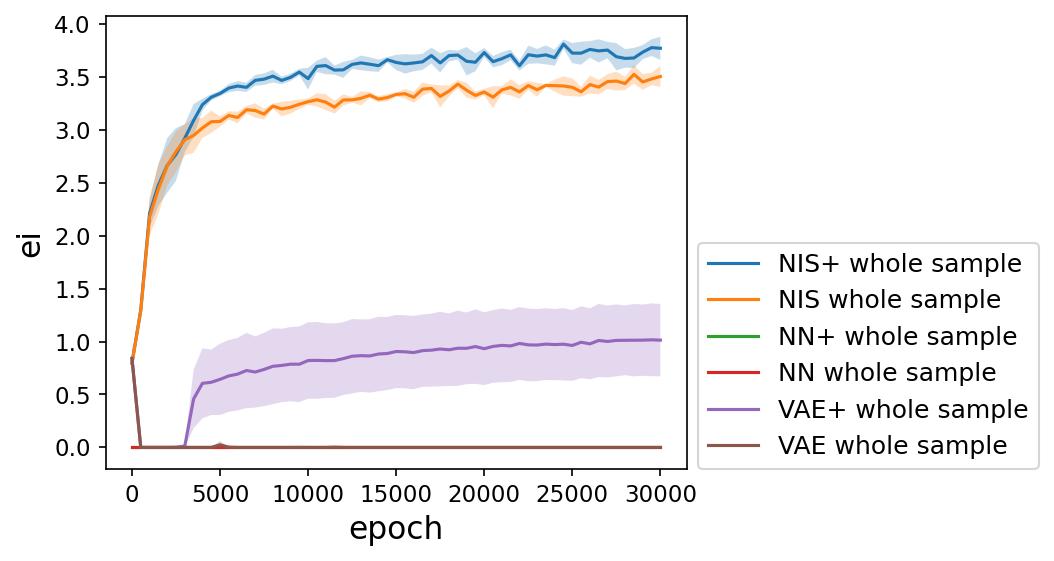

In [5]:
#Plot EI 
import pickle
def resultprocess(results,results_nn,com_index = 0):
    compare1 = []; compare2 = [];
    for i in range(len(results)):
        rresult = results[i]
        rresult_nn=results_nn[i]
        timeseries1 = [k[com_index] for k in rresult]  # ei0[0]
        timeseries2 = [k[com_index] for k in rresult_nn]  #
        compare1.append(timeseries1)
        compare2.append(timeseries2)
    #print('timeseries1=',timeseries1,'timeseries2=',timeseries2)
    compare1 = np.array(compare1)
    compare2 = np.array(compare2)
    if com_index==3:
        T=len(compare1[0,3:])
        compare1=np.cumsum(compare1[:,3:],1)/np.linspace(1, T, T)
        compare2=np.cumsum(compare2[:,3:],1)/np.linspace(1, T, T)
    meanv1 = np.mean(compare1, 0)
    meanv2 = np.mean(compare2, 0)
    stdv1 = np.std(compare1, 0)
    stdv2 = np.std(compare2, 0)
    return meanv1,meanv2,stdv1,stdv2

with open('NN part experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv_nn_ood,meanv_nn__ood,stdv_nn_ood,stdv_nn__ood=resultprocess(results,results_nn)
with open('NN whole experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv_nn_whole,meanv_nn__whole,stdv_nn_whole,stdv_nn__whole=resultprocess(results,results_nn)
with open('VAE whole experiments2.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
results=[results[0],results[2],results[4]]
results_nn=[results_nn[0],results_nn[2],results_nn[4]]
meanv_vae_whole,meanv_vae__whole,stdv_vae_whole,stdv_vae__whole=resultprocess(results,results_nn,com_index = 0)
with open('VAE part experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv_vae_ood,meanv_vae__ood,stdv_vae_ood,stdv_vae__ood=resultprocess(results,results_nn,com_index = 0)
with open('5 OOD L=1 717.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv1_ood,meanv2_ood,stdv1_ood,stdv2_ood=resultprocess(results,results_nn)
with open('5 whole L=1.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv1_whole,meanv2_whole,stdv1_whole,stdv2_whole=resultprocess(results,results_nn)
timesteps = np.arange(len(meanv1_ood)) * 500
plt.figure(figsize=(5, 4),dpi=150)
plt.plot(timesteps, meanv1_whole, label='NIS+ whole sample')
plt.fill_between(timesteps, meanv1_whole-stdv1_whole, meanv1_whole+stdv1_whole,alpha=0.25)
plt.plot(timesteps, meanv2_whole, label='NIS whole sample')
plt.fill_between(timesteps, meanv2_whole-stdv2_whole, meanv2_whole+stdv2_whole,alpha=0.25)
plt.plot(timesteps, meanv_nn_whole, label='NN+ whole sample')
plt.fill_between(timesteps, meanv_nn_whole-stdv_nn_whole, meanv_nn_whole+stdv_nn_whole,alpha=0.25)
plt.plot(timesteps, meanv_nn__whole, label='NN whole sample')
plt.fill_between(timesteps, meanv_nn__whole-stdv_nn__whole, meanv_nn__whole+stdv_nn__whole,alpha=0.25)
plt.plot(timesteps, meanv_vae_whole, label='VAE+ whole sample')
plt.fill_between(timesteps, meanv_vae_whole-stdv_vae_whole, meanv_vae_whole+stdv_vae_whole,alpha=0.25)
plt.plot(timesteps, meanv_vae__whole, label='VAE whole sample')
plt.fill_between(timesteps, meanv_vae__whole-stdv_vae__whole, meanv_vae__whole+stdv_vae__whole,alpha=0.25)
#plt.title('dEI Repeated Experiments')
plt.xlabel('epoch',fontsize=15)
plt.ylabel('ei',fontsize=15)
#plt.ylabel('$\mathcal{J}$',fontsize=15)
plt.tick_params(labelsize=11)
plt.legend(loc=(1.02,0), fontsize=12)

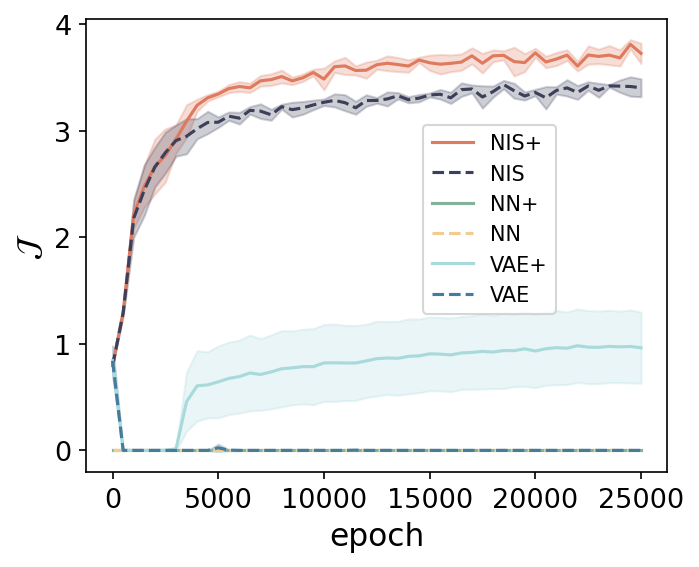

In [6]:
timesteps = np.arange(len(meanv1_ood))[:-10] * 500
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4),dpi=150)
#Plot EI
color_palette = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']#sns.color_palette('husl', 6)
#colorlabel = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
plt.plot(timesteps, meanv1_whole[:-10], label='NIS+', color=color_palette[1],linestyle='solid')
plt.fill_between(timesteps, meanv1_whole[:-10]-stdv1_whole[:-10], meanv1_whole[:-10]+stdv1_whole[:-10], color=color_palette[1], alpha=0.25)

plt.plot(timesteps, meanv2_whole[:-10], label='NIS', color=color_palette[2],linestyle='dashed')
plt.fill_between(timesteps, meanv2_whole[:-10]-stdv2_whole[:-10], meanv2_whole[:-10]+stdv2_whole[:-10], color=color_palette[2], alpha=0.25)

plt.plot(timesteps, meanv_nn_whole[:-10], label='NN+', color=color_palette[3],linestyle='solid')
plt.fill_between(timesteps, meanv_nn_whole[:-10]-stdv_nn_whole[:-10], meanv_nn_whole[:-10]+stdv_nn_whole[:-10], color=color_palette[3], alpha=0.25)

plt.plot(timesteps, meanv_nn_whole[:-10], label='NN', color=color_palette[4],linestyle='dashed')
plt.fill_between(timesteps, meanv_nn__whole[:-10]-stdv_nn__whole[:-10], meanv_nn__whole[:-10]+stdv_nn__whole[:-10], color=color_palette[4], alpha=0.25)

plt.plot(timesteps, meanv_vae_whole[:-10], label='VAE+', color=color_palette[5],linestyle='solid')
plt.fill_between(timesteps, meanv_vae_whole[:-10]-stdv_vae_whole[:-10], meanv_vae_whole[:-10]+stdv_vae_whole[:-10], color=color_palette[5], alpha=0.25)

plt.plot(timesteps, meanv_vae__whole[:-10], label='VAE', color=color_palette[6],linestyle='dashed')
plt.fill_between(timesteps, meanv_vae__whole[:-10]-stdv_vae__whole[:-10], meanv_vae__whole[:-10]+stdv_vae__whole[:-10], color=color_palette[6], alpha=0.25)


plt.xlabel('epoch', fontsize=15)
#plt.ylabel('loss', fontsize=15)
plt.ylabel('$\mathcal{J}$', fontsize=15)
plt.tick_params(labelsize=13)
plt.legend(loc=[0.58,0.35], fontsize=10)
plt.show()

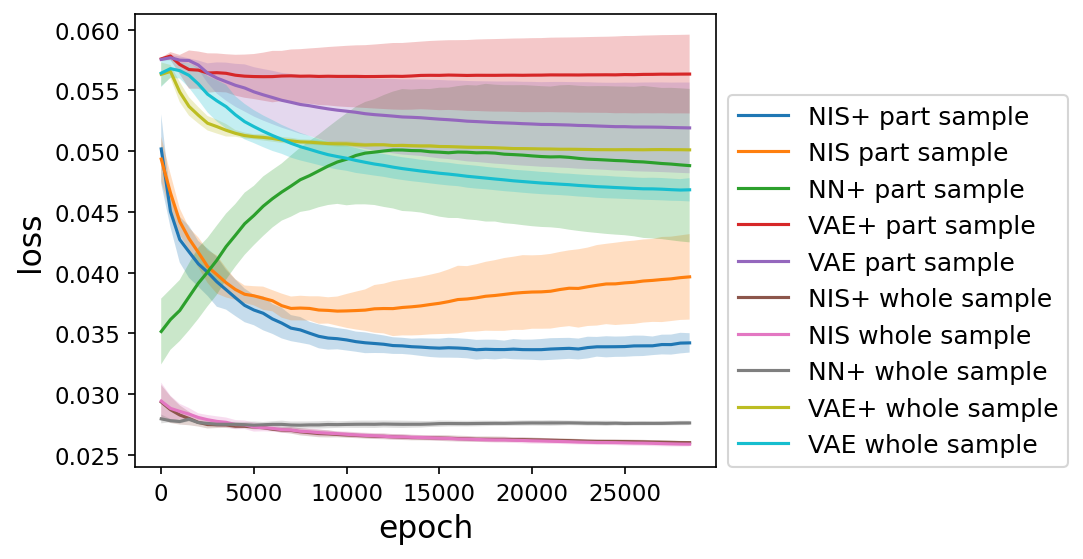

In [7]:
#Plot Multi-step Prediction Error during training
import pickle
def resultprocess(results,results_nn,com_index = 3):
    compare1 = []; compare2 = [];
    for i in range(len(results)):
        rresult = results[i]
        rresult_nn=results_nn[i]
        timeseries1 = [k[com_index] for k in rresult]  # ei0[0]
        timeseries2 = [k[com_index] for k in rresult_nn]  #
        compare1.append(timeseries1)
        compare2.append(timeseries2)
    #print('timeseries1=',timeseries1,'timeseries2=',timeseries2)
    compare1 = np.array(compare1)
    compare2 = np.array(compare2)
    if com_index==3 or com_index==1:
        T=len(compare1[0,3:])
        compare1=np.cumsum(compare1[:,3:],1)/np.linspace(1, T, T)
        compare2=np.cumsum(compare2[:,3:],1)/np.linspace(1, T, T)
    meanv1 = np.mean(compare1, 0)
    meanv2 = np.mean(compare2, 0)
    stdv1 = np.std(compare1, 0)
    stdv2 = np.std(compare2, 0)
    return meanv1,meanv2,stdv1,stdv2

with open('NN part experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv_nn_ood,meanv_nn__ood,stdv_nn_ood,stdv_nn__ood=resultprocess(results,results_nn)
with open('NN whole experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv_nn_whole,meanv_nn__whole,stdv_nn_whole,stdv_nn__whole=resultprocess(results,results_nn)
with open('VAE whole experiments2.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
results=[results[0],results[2],results[4]]
results_nn=[results_nn[0],results_nn[2],results_nn[4]]
meanv_vae_whole,meanv_vae__whole,stdv_vae_whole,stdv_vae__whole=resultprocess(results,results_nn,com_index = 1)
with open('VAE part experiments.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
results=[results[0],results[2],results[3],results[4]]
results_nn=[results_nn[0],results_nn[2],results[3],results_nn[4]]
meanv_vae_ood,meanv_vae__ood,stdv_vae_ood,stdv_vae__ood=resultprocess(results,results_nn,com_index = 1)
with open('5 OOD L=1 717.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv1_ood,meanv2_ood,stdv1_ood,stdv2_ood=resultprocess(results,results_nn)
with open('5 whole L=1.pkl', 'rb') as f:
    results,results_nn = pickle.load(f)
meanv1_whole,meanv2_whole,stdv1_whole,stdv2_whole=resultprocess(results,results_nn)
timesteps = np.arange(len(meanv1_ood)) * 500
plt.figure(figsize=(5, 4),dpi=150)
plt.plot(timesteps, meanv1_ood, label='NIS+ part sample')
plt.fill_between(timesteps, meanv1_ood-stdv1_ood, meanv1_ood+stdv1_ood,alpha=0.25)
plt.plot(timesteps, meanv2_ood, label='NIS part sample')
plt.fill_between(timesteps, meanv2_ood-stdv2_ood, meanv2_ood+stdv2_ood,alpha=0.25)
plt.plot(timesteps, meanv_nn_ood, label='NN+ part sample')
plt.fill_between(timesteps, meanv_nn_ood-stdv_nn_ood, meanv_nn_ood+stdv_nn_ood,alpha=0.25)
plt.plot(timesteps, meanv_vae_ood, label='VAE+ part sample')
plt.fill_between(timesteps, meanv_vae_ood-stdv_vae_ood, meanv_vae_ood+stdv_vae_ood,alpha=0.25)
plt.plot(timesteps, meanv_vae__ood, label='VAE part sample')
plt.fill_between(timesteps, meanv_vae__ood-stdv_vae__ood, meanv_vae__ood+stdv_vae__ood,alpha=0.25)
plt.plot(timesteps, meanv1_whole, label='NIS+ whole sample')
plt.fill_between(timesteps, meanv1_whole-stdv1_whole, meanv1_whole+stdv1_whole,alpha=0.25)
plt.plot(timesteps, meanv2_whole, label='NIS whole sample')
plt.fill_between(timesteps, meanv2_whole-stdv2_whole, meanv2_whole+stdv2_whole,alpha=0.25)
plt.plot(timesteps, meanv_nn_whole, label='NN+ whole sample')
plt.fill_between(timesteps, meanv_nn_whole-stdv_nn_whole, meanv_nn_whole+stdv_nn_whole,alpha=0.25)
plt.plot(timesteps, meanv_vae_whole, label='VAE+ whole sample')
plt.fill_between(timesteps, meanv_vae_whole-stdv_vae_whole, meanv_vae_whole+stdv_vae_whole,alpha=0.25)
plt.plot(timesteps, meanv_vae__whole, label='VAE whole sample')
plt.fill_between(timesteps, meanv_vae__whole-stdv_vae__whole, meanv_vae__whole+stdv_vae__whole,alpha=0.25)
#plt.title('dEI Repeated Experiments')
plt.xlabel('epoch',fontsize=15)
plt.ylabel('loss',fontsize=15)
#plt.ylabel('$\mathcal{J}$',fontsize=15)
plt.tick_params(labelsize=11)
plt.legend(loc=(1.02,0), fontsize=12)

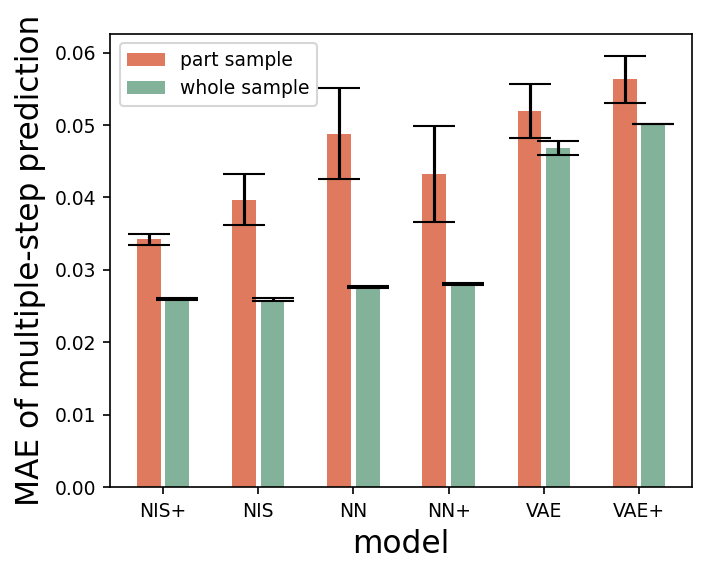

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Plot Multi-step Prediction Error
colorlabel = ['#F4F1DE','#DF7A5E','#3C405B','#82B29A','#F2CC8E']
means = [meanv1_ood[-1], meanv2_ood[-1], meanv_nn_ood[-1],meanv_nn__ood[-1],meanv_vae__ood[-1],meanv_vae_ood[-1]]
std_devs = [stdv1_ood[-1], stdv2_ood[-1], stdv_nn_ood[-1],stdv_nn__ood[-1],stdv_vae__ood[-1],stdv_vae_ood[-1]]
means_all = [meanv1_whole[-1], meanv2_whole[-1], meanv_nn_whole[-1],meanv_nn__whole[-1],meanv_vae__whole[-1],meanv_vae_whole[-1]]
std_devs_all = [stdv1_whole[-1], stdv2_whole[-1], stdv_nn_whole[-1],stdv_nn__whole[-1],stdv_vae__whole[-1],stdv_vae_whole[-1]]

fig, ax = plt.subplots(figsize=(5,4),dpi=150)

bar_positions = np.arange(0,11,2)+0.2
bar_positions2 = np.arange(1,12,2)-0.2
bar_width = 0.5

bars = ax.bar(bar_positions, means, width=bar_width, color=colorlabel[1], yerr=std_devs, capsize=10,label='part sample')
bars2 = ax.bar(bar_positions2, means_all, width=bar_width, color=colorlabel[3], yerr=std_devs_all, capsize=10,label='whole sample')
plt.legend(fontsize=9)
ax.set_xlabel('model',fontsize=15)
ax.set_ylabel('MAE of multiple-step prediction', fontsize=15)
plt.tick_params(labelsize=9)
ax.set_xticks(0.5*(bar_positions+bar_positions2))
ax.set_xticklabels(['NIS+', 'NIS', 'NN','NN+','VAE',"VAE+"])

plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#Draw grid points for the vector field.
def mesh(density):
    p1 = np.array([0, 0])
    p2 = np.array([0, 1])
    p3 = np.array([1, 0])

    #Generate an array of coordinates for grid points.
    x_min, x_max = -1, 6
    y_min, y_max = -1, 6
    x_range = np.arange(x_min, x_max, density)
    y_range = np.arange(y_min, y_max, density)
    X, Y = np.meshgrid(x_range, y_range)

    # Determine if each grid point is inside the right-angled triangle.
    in_triangle = np.zeros(X.shape, dtype=bool)
    for i in range(len(X)):
        for j in range(len(X[i])):
            p = np.array([X[i][j], Y[i][j]])
            if p[0] >= 0 and p[1] >= 0 and p[0]+p[1] <= 1 :
                in_triangle[i, j] = True

    # Grid points marked within a right-angled triangle.
    x_in = X[in_triangle]
    y_in = Y[in_triangle]

    return x_in, y_in

def transit(ss,sps,density):
    whole=torch.cat((ss,sps),0)
    xmax=whole[:,0].max()
    xmin=whole[:,0].min()
    ymax=whole[:,1].max()
    ymin=whole[:,1].min()
    numberx=(xmax-xmin)/density
    numberx=int(numberx.item())+1
    numbery=(ymax-ymin)/density
    numbery=int(numbery.item())+1
    number=numberx*numbery
    count = torch.zeros(numberx, numbery, numberx, numbery,device=device)
    h1=np.arange(xmin.cpu().detach().numpy(), xmax.cpu().detach().numpy(), density)
    h2=np.arange(ymin.cpu().detach().numpy(), ymax.cpu().detach().numpy(), density)
   
    cpt('start')
    for i in range(numberx):
        for j in range(numbery):
            ss0=(ss[:,0] >= xmin + i*density) & (ss[:,0] < xmin + (i+1)*density) & (ss[:,1] >= ymin + j*density) & (ss[:,1] < ymin + (j+1)*density)
            indices = torch.nonzero(ss0).squeeze()
            indices = torch.flatten(indices).cpu().numpy()
            for i2 in range(numberx):
                for j2 in range(numbery):
                    for k in indices:
                        if (sps[k,0] >= xmin + i2*density) & (sps[k,0] < xmin + (i2+1)*density) & (sps[k,1] >= ymin + j2*density) & (sps[k,1] < ymin + (j2+1)*density):
                            count[i,j,i2,j2]+=1


    count_mean=torch.zeros(numberx, numbery, 2)
    for i in range(numberx):
        for j in range(numbery):
            x_m=[]
            y_m=[]
            for i2 in range(numberx):
                for j2 in range(numbery):
                    x=count[i,j,i2,j2]*(i2-i)*density
                    y=count[i,j,i2,j2]*(j2-j)*density
                    x_m.append(x.item()) 
                    y_m.append(y.item())
            count_mean[i,j,0]=np.sum(x_m)/np.sum(count[i,j,:,:].cpu().detach().numpy())
            count_mean[i,j,1]=np.sum(y_m)/np.sum(count[i,j,:,:].cpu().detach().numpy())

    return count_mean,h1,h2

mesh(0.05)

(array([8.8817842e-16, 5.0000000e-02, 1.0000000e-01, 1.5000000e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000000e-01, 3.5000000e-01,
        4.0000000e-01, 4.5000000e-01, 5.0000000e-01, 5.5000000e-01,
        6.0000000e-01, 6.5000000e-01, 7.0000000e-01, 7.5000000e-01,
        8.0000000e-01, 8.5000000e-01, 9.0000000e-01, 9.5000000e-01,
        8.8817842e-16, 5.0000000e-02, 1.0000000e-01, 1.5000000e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000000e-01, 3.5000000e-01,
        4.0000000e-01, 4.5000000e-01, 5.0000000e-01, 5.5000000e-01,
        6.0000000e-01, 6.5000000e-01, 7.0000000e-01, 7.5000000e-01,
        8.0000000e-01, 8.5000000e-01, 9.0000000e-01, 8.8817842e-16,
        5.0000000e-02, 1.0000000e-01, 1.5000000e-01, 2.0000000e-01,
        2.5000000e-01, 3.0000000e-01, 3.5000000e-01, 4.0000000e-01,
        4.5000000e-01, 5.0000000e-01, 5.5000000e-01, 6.0000000e-01,
        6.5000000e-01, 7.0000000e-01, 7.5000000e-01, 8.0000000e-01,
        8.5000000e-01, 8.8817842e-16, 5.0000000e

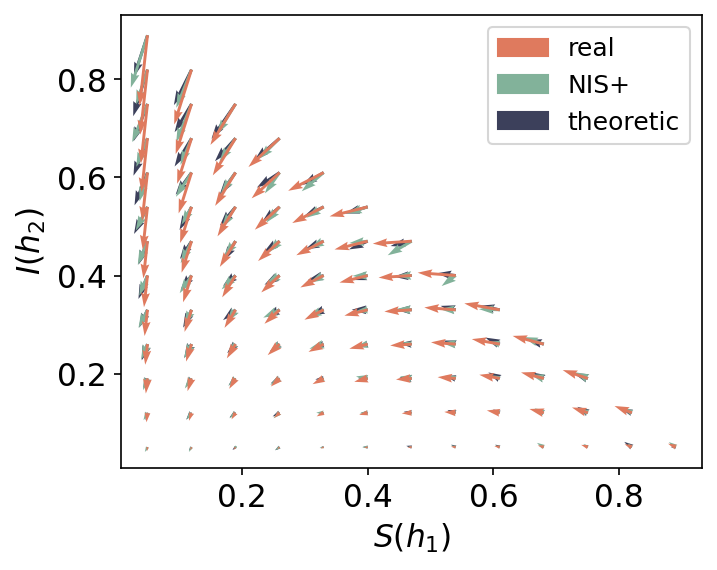

In [10]:
#Construct NIS and NIS+ vector fields using pre-generated data
import matplotlib
with open('SIR_vector_final_07.pkl', 'rb') as file:
    data = pickle.load(file)

dd1_final = data['dd1_final']
dd2_final = data['dd2_final']
dd1_final_nis = data['dd1_final_nis']
dd2_final_nis = data['dd2_final_nis']

def SIR(s,i,lam=1,miu=0.5):
    ds=-lam * s * i
    di=lam * s * i - miu * i
    return ds, di
S, I = mesh(0.07)
dSdt,dIdt = SIR(S,I)
m=0.1
dSdt,dIdt=m*dSdt,m*dIdt
fig,ax = plt.subplots(figsize=(5,4),dpi=150)
colors=[colorlabel[2]]*len(S)+[colorlabel[3]]*len(S)+[colorlabel[1]]*len(S)
S=list(S)+list(S)+list(S)
I=list(I)+list(I)+list(I)
#dd1_final=list(dd1_net)+list(dd1_net_jac)+list(dSdt)
#dd2_final=list(dd2_net)+list(dd2_net_jac)+list(dIdt)
quiver = ax.quiver(S, I, dd1_final, dd2_final, width=0.005,color=colors)
#quiver = ax.quiver(S, I, dd1_final_nis, dd2_final_nis, width=0.005,color=colors)
red_patch = matplotlib.patches.Patch(color=colorlabel[1], label='real')
green_patch = matplotlib.patches.Patch(color=colorlabel[3], label='NIS+')
ran_patch = matplotlib.patches.Patch(color=colorlabel[2], label='theoretic')
plt.legend(handles=[red_patch, green_patch,ran_patch],loc='best', fontsize=12)

# Set graphic title and axis labels.
plt.xlabel('$S(h_1)$',fontsize=15)
plt.ylabel('$I(h_2)$',fontsize=15)

ax.tick_params(labelsize=15)
plt.show()

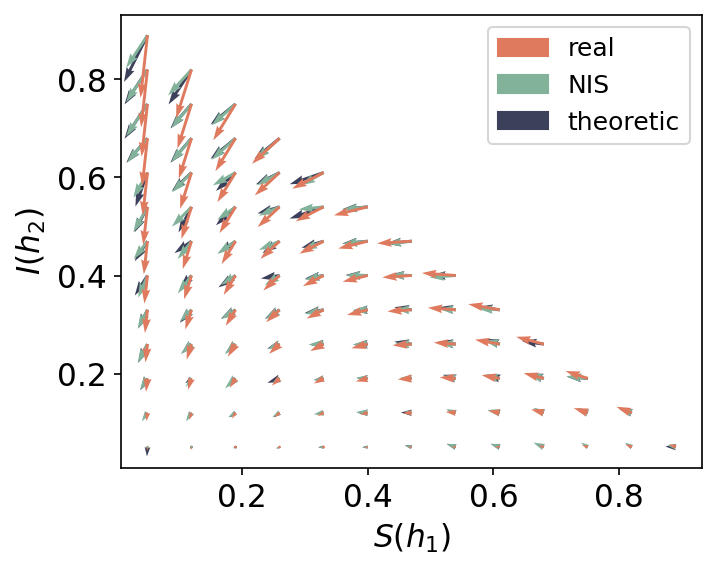

In [11]:
import matplotlib
with open('SIR_vector_final_07.pkl', 'rb') as file:
    data = pickle.load(file)

dd1_final = data['dd1_final']
dd2_final = data['dd2_final']
dd1_final_nis = data['dd1_final_nis']
dd2_final_nis = data['dd2_final_nis']

def SIR(s,i,lam=1,miu=0.5):
    ds=-lam * s * i
    di=lam * s * i - miu * i
    return ds, di
S, I = mesh(0.07)
dSdt,dIdt = SIR(S,I)
m=0.1
dSdt,dIdt=m*dSdt,m*dIdt
fig,ax = plt.subplots(figsize=(5,4),dpi=150)
colors=[colorlabel[2]]*len(S)+[colorlabel[3]]*len(S)+[colorlabel[1]]*len(S)
S=list(S)+list(S)+list(S)
I=list(I)+list(I)+list(I)
#dd1_final=list(dd1_net)+list(dd1_net_jac)+list(dSdt)
#dd2_final=list(dd2_net)+list(dd2_net_jac)+list(dIdt)
#quiver = ax.quiver(S, I, dd1_final, dd2_final, width=0.005,color=colors)
quiver = ax.quiver(S, I, dd1_final_nis, dd2_final_nis, width=0.005,color=colors)
red_patch = matplotlib.patches.Patch(color=colorlabel[1], label='real')
green_patch = matplotlib.patches.Patch(color=colorlabel[3], label='NIS')
ran_patch = matplotlib.patches.Patch(color=colorlabel[2], label='theoretic')
plt.legend(handles=[red_patch, green_patch,ran_patch],loc='best', fontsize=12)

# Set graphic title and axis labels.
plt.xlabel('$S(h_1)$',fontsize=15)
plt.ylabel('$I(h_2)$',fontsize=15)

ax.tick_params(labelsize=15)
plt.show()

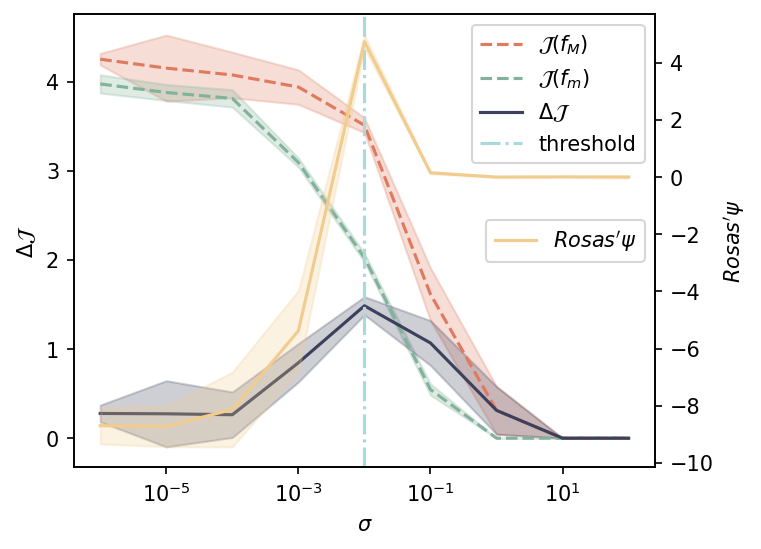

In [12]:
#Comparison of CE and Rosas' Psi
import pickle

with open('sir_e.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_list = data['sigma_list']
macro_mean = data['macro_mean']
macro_std = data['macro_std']
micro_mean = data['micro_mean']
micro_std = data['micro_std']
CE_mean = data['CE_mean']
CE_std = data['CE_std']
psi_mean = data['psi_mean']
psi_std = data['psi_std']
v_mean = data['v_mean']
v_std = data['v_std']
x_mean = data['x_mean']
x_std = data['x_std']

import matplotlib.pyplot as plt

colorlabel = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']

fig, ax1 = plt.subplots(figsize=(5, 4), dpi=150)

ax1.plot(sigma_list, macro_mean, color=colorlabel[1], linestyle='--', label='$\mathcal{J}(f_M)$')
ax1.fill_between(sigma_list, macro_mean - macro_std, macro_mean + macro_std, color=colorlabel[1], alpha=0.25)

ax1.plot(sigma_list, micro_mean, color=colorlabel[3], linestyle='--', label='$\mathcal{J}(f_m)$')
ax1.fill_between(sigma_list, micro_mean - micro_std, micro_mean + micro_std, color=colorlabel[3], alpha=0.25)

ax1.plot(sigma_list, CE_mean, color=colorlabel[2], label='$\Delta\mathcal{J}$')
ax1.fill_between(sigma_list, CE_mean - CE_std, CE_mean + CE_std, color=colorlabel[2], alpha=0.25)

ax1.set_xlabel('$\sigma$')
ax1.set_ylabel('$\Delta\mathcal{J}$')
ax1.axvline(x=0.01, color=colorlabel[5], linestyle='-.',label='threshold')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.plot(sigma_list, psi_mean, color=colorlabel[4], label="$Rosas' \psi$")
ax2.fill_between(sigma_list, psi_mean - psi_std, psi_mean + psi_std, color=colorlabel[4], alpha=0.25)
ax2.set_ylabel("$Rosas' \psi$")

ax2.legend(loc='center right')

ax1.set_xscale('log')

plt.show()